<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>Variable Stars in DP0.2</b> <br>
Contact author(s): Jeff Carlin and Ryan Lau <br>
Last verified to run: 2024-01-31 <br>
LSST Science Pipelines version: Weekly 2024_04 <br>
Container Size: medium <br>
Targeted learning level: intermediate <br>

**Description:** Use catalog data to identify variable stars and plot their lightcurves. **Adapted to use the dp02_dc2_catalogs_frdf catalogs produced at CC-IN2P3.**

**Skills:** Use various TAP tables, including joining multiple tables. Extract time-series photometry. Measure periods and plot phased lightcurves.

**LSST Data Products:** TAP tables dp02_dc2_catalogs_frdf.Object, ForcedSource, CcdVisit, DiaObject, DiaSource, ForcedSourceOnDiaObject<br>

**Packages:** numpy, matplotlib, astropy.units, astropy.coordinates, astropy.io.fits, astropy.timeseries.LombScargle, lsst.rsp.get_tap_service

**Credit:** Originally developed by Jeff Carlin and the Community Science Team for Rubin Data Preview 0 with improvements contributed by Bob Abel and updates contributed by Ryan Lau.<br>

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook demonstrates use of the Table Access Protocol (TAP) service to query the time-domain data products at the location of a known RR Lyrae variable star.

In Section 2 a known RR Lyrae star is identified in the `Object` table, and then photometry is retrieved from the `ForcedSource` table.
Recall that the `Object` table contains astrometric and photometric measurements for objects detected in coadded images, and that
the `ForcedSource` table contains forced photometry on the individual processed visit images (PVIs; direct images)
at the locations of all detected `Objects`. 
A Lomb-Scargle periodogram is used to identify the period and phase-fold the time-series photometry, and then
a phase-folded lightcurve is displayed for the single RR Lyrae.

In Section 3 the data products of difference image analysis (DIA), in particular the lightcurve summary statistic parameters
available in the `DiaObject` table, are used to identify a sample of likely RR Lyrae from the DP0.2 data set. 

A cautionary tale on the difference between using time-series photometry for `DiaObjects` in the `DiaSource` or `ForcedSourceOnDiaObject` tables is demonstrated in Section 3.4.
Both contain forced photometry in the PVI (direct image), but the `DiaSource` table only contains photometry for visits in which the
`DiaObject` was *detected in the corresponding difference image*,
whereas the `ForcedSourceOnDiaObject` table contains forced photometry for *all* PVIs and difference images.

> **Warning:** When variable stars are observed to have nearly the same brightness as they do in the template image,
they will not be detected in the difference image,
and photometry for that visit's PVI will not be included in the `DiaSource` table.

This notebook demonstrates that, for variable stars, it is better to use either the `ForcedSource` or `ForcedSourceOnDiaObject` tables.

### 1.1 Package Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import unique
from astropy.timeseries import LombScargle
from lsst.rsp import get_tap_service

### 1.2 Define Functions and Parameters

Set up some plotting defaults so plots will look nice:

In [2]:
%matplotlib inline
plt.style.use('tableau-colorblind10')
params = {'axes.labelsize': 24,
          'font.size': 20,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [10, 8],
          'figure.facecolor': 'White'}
plt.rcParams.update(params)

Set up colors and plot symbols corresponding to the _ugrizy_ bands. These colors are the same as those used for _ugrizy_ bands in Dark Energy Survey (DES) publications, and are defined in <a href="https://github.com/DarkEnergySurvey/descolors">this github repository</a>.

In [3]:
plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

Start the TAP service, which we will use for all data retrieval in this notebook.

In [4]:
service = get_tap_service("tap")

## 2. Create a Lightcurve for a Known RR Lyrae Variable

To start out, we will use a star that is known (from the DC2 truth tables) to be a simulated RR Lyrae star in DC2. This will help us get our feet wet at extracting time-series data and manipulating them.



### 2.1 Extract Forced Photometry Measurements for a Pulsating Variable

The known RR Lyrae star we will use is at position (RA, Dec) = (62.1479031, -35.799138) degrees. We will initially look for this star in the `Object` table to identify its `objectId`. Then we will use this `objectId` to identify measurements of the star in the `ForcedSource` table.

#### 2.1.1 Define star coordinates

Initialize two variables with the known position of the star of interest:

In [5]:
ra_known_rrl = 62.1479031
dec_known_rrl = -35.799138

#### 2.1.2 Find the Star in the Object Table

Query the `Object` table for this star. We use a spatial query at the RA, Dec position of interest, and specify a very small area to search (0.001 degrees), so that we will retrieve only the star of interest.

Notice that in addition to selecting on position, we specify "detect_isPrimary = 1" as well. The <a href="https://pipelines.lsst.io/getting-started/multiband-analysis.html#filtering-for-unique-deblended-sources-with-the-detect-isprimary-flag">detect_isPrimary flag</a> is a composite flag that, if TRUE (or set to 1), ensures a unique, deblended source.

Notice also the use of the `scisql_nanojanskyToAbMag` function to convert fluxes to magnitudes. (This could also be done after extracting the fluxes if desired, but this step streamlines things.)

In [6]:
results = service.search("SELECT TOP 100 "
                         "coord_ra, coord_dec, objectId, "
                         "g_psfFlux, r_psfFlux, i_psfFlux, detect_isPrimary, "
                         "scisql_nanojanskyToAbMag(g_psfFlux) as gPSFMag, "
                         "scisql_nanojanskyToAbMag(r_psfFlux) as rPSFMag, "
                         "scisql_nanojanskyToAbMag(i_psfFlux) as iPSFMag, "
                         "g_extendedness, r_extendedness, i_extendedness "
                         "FROM dp02_dc2_catalogs_frdf.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         "CIRCLE('ICRS'," + str(ra_known_rrl) + ", "
                         + str(dec_known_rrl) + ", 0.001)) = 1 "
                         "AND detect_isPrimary = 1")

objs = results.to_table()

In [7]:
objs

coord_ra,coord_dec,objectId,g_psfFlux,r_psfFlux,i_psfFlux,detect_isPrimary,gPSFMag,rPSFMag,iPSFMag,g_extendedness,r_extendedness,i_extendedness
deg,deg,,nJy,nJy,nJy,,,,,,,
float64,float64,int64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64
62.1479018,-35.7991382,1651589610221899038,148048.9266238,185964.388121,173109.3568595,True,18.473986842403193,18.226425536273844,18.304198642809727,0.0,0.0,0.0


Looks good - our limited search retrieved only a single object. Notice that the "extendedness" flag is zero for all three bands, meaning this object is likely a point source (i.e., a star). It is around 18th magnitude in all three bands, and has fairly blue colors as expected for an RR Lyrae star.

#### 2.1.3 Extract the Measurements from the Forced Source Table

Now that we have identified the candidate in the Object table, we can use its `objectId` to identify it in the `ForcedSource` table. First extract the `objectId`:

In [8]:
sel_objid = objs[0]['objectId']
print(sel_objid)

1651589610221899038


Now we will use this ID to pick out all measurements of this object from the `ForcedSource` table (by use of a WHERE statement in the query).

Note that we are also using a JOIN here to extract the visit info for each entry in `ForcedSource`. This is necessary so we can get the time each exposure was observed ("expMidptMJD"), to be used in constructing lightcurves.

Define the query.

In [9]:
query = "SELECT src.band, src.ccdVisitId, src.coord_ra, src.coord_dec, "\
        "src.objectId, src.psfFlux, src.psfFluxErr, "\
        "scisql_nanojanskyToAbMag(psfFlux) as psfMag, "\
        "visinfo.ccdVisitId, visinfo.band, "\
        "visinfo.expMidptMJD, visinfo.zeroPoint "\
        "FROM dp02_dc2_catalogs_frdf.ForcedSource as src "\
        "JOIN dp02_dc2_catalogs_frdf.CcdVisit as visinfo "\
        "ON visinfo.ccdVisitId = src.ccdVisitId "\
        "WHERE src.objectId = "+str(sel_objid)+" "


Execute the query, and extract the results to a table.

In [10]:
results = service.search(query)
srcs = results.to_table()
print(len(srcs))

864


Uncomment and execute the following cell to see what this table looks like.

In [11]:
# srcs

#### 2.1.4 Select Forced Photometry Measurements from Each Band

The `ForcedSource` table contains measurements from all bands (i.e., _ugrizy_ filters). It will be useful to extract measurements for each band by selecting on the "band" column.

In the following cell, and throughout this notebook, we store arrays in a python dict (in this case, one called "pick") that is indexed on the "band" or "filter" name.

In [12]:
pick = {}
for filter in plot_filter_labels:
    pick[filter] = (srcs['band'] == filter)

Plot the observed "lightcurve" for the _r_ band.

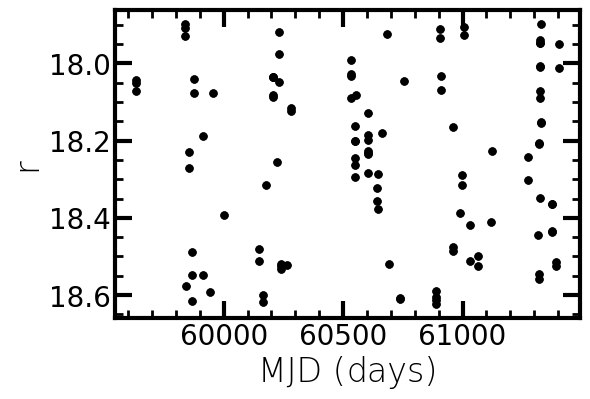

In [13]:
fig = plt.figure(figsize=(6, 4))
plt.plot(srcs[pick['r']]['expMidptMJD'], srcs[pick['r']]['psfMag'],
         'k.', ms=10)
plt.minorticks_on()
plt.xlabel('MJD (days)')
plt.ylabel('r')
plt.gca().invert_yaxis()
plt.show()

There is a spread of almost 1 magnitude, so clearly we have identified a variable star. Hooray!

### 2.2 Create a Phased Lightcurve

In the plot above, it is clear that this is a variable star, but we want to know more about it. Assuming it is a periodic variable, let's try to estimate its period so we can create a phased lightcurve.

> **Caveat:** The author of this notebook is not an expert in periodic variables or analysis of time-series data. The following is almost certainly not the **best** way of doing these analyses, but is simply one way to do things. It is shown here as a demonstration only.

A common way of searching for periodicity in unevenly-sampled time-series data is the Lomb-Scargle Periodogram. In this section we will create such a periodogram using the <a href="https://docs.astropy.org/en/stable/timeseries/lombscargle.html">Lomb-Scargle package from Astropy</a>. We will then estimate the best period, and reference all observations to that period to create a phased lightcurve.


#### 2.2.1 Extract and Plot a Periodogram

For convenience, we first extract all of the times of observation and measured magnitudes to separate arrays for each bandpass.

In [14]:
mjd_days = {}
mags = {}
for filter in plot_filter_labels:
    mjd_days[filter] = np.array(srcs[pick[filter]]['expMidptMJD']) * u.day
    mags[filter] = np.array(srcs[pick[filter]]['psfMag'])

The Lomb-Scargle periodogram returns the power at different frequencies. Because we know this is an RR Lyrae star, its period must be between ~0.2-0.9 days. We will use the min/max frequency settings to limit our period search to 0.05-1.05 days. (Recall that frequency is 1/period.)

In [15]:
min_period = 0.05 * u.day
max_period = 1.05 * u.day

min_freq_search = 1.0 / max_period
max_freq_search = 1.0 / min_period

Now we run the LombScargle algorithm on each of these datasets. We will set only the min/max frequencies, and otherwise use the "autopower" method from LombScargle. 

In [16]:
frequency = {}
power = {}
for filter in plot_filter_labels:
    frequency[filter], power[filter] =\
        LombScargle(mjd_days[filter], mags[filter]).autopower(minimum_frequency=min_freq_search,
                                                              maximum_frequency=max_freq_search)


In a well-behaved and well-sampled scenario, the Lomb-Scargle power will peak at a specific frequency that corresponds to the period of the star's variability.

We will assume that the frequency returning the highest power corresponds to the real period of the star (which is not necessarily true in the case of real data with uneven sampling, period aliasing, and other effects). Let's find this frequency for each band.

In the following cell, we find the index with the maximum power and assign it as the "peakbin" and then store the frequency according to the peak power. Then we calculate the mean frequency and period from the peak frequencies of the results from all the filters.

In [17]:
all_peak_freqs = []

for filter in plot_filter_labels:
    peakbin = np.argmax(power[filter])

    all_peak_freqs.append(frequency[filter][peakbin].value)
    
all_peak_freqs = np.array(all_peak_freqs)

mean_peak_freq = np.mean(all_peak_freqs)

print('Mean frequency:', mean_peak_freq)
print('Mean period:', 1.0/mean_peak_freq, ' days')
print('\nugrizy frequency results:\n', all_peak_freqs)

Mean frequency: 1.962589383860051
Mean period: 0.5095309330743371  days

ugrizy frequency results:
 [1.96261051 1.96261062 1.96261288 1.96252393 1.96255106 1.9626273 ]


Plot a "periodogram" -- a figure showing the power vs. frequency from the Lomb-Scargle analysis. We'll also add a panel for the period. (This figure shows only the r-band results. You could try it with others!)

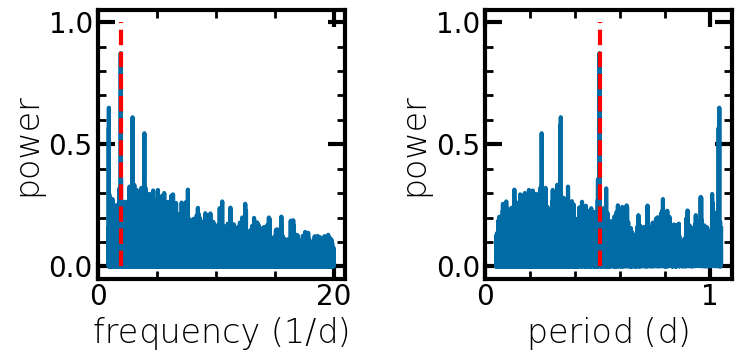

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(ax[0])
plt.plot(frequency['r'], power['r'])
plt.vlines(mean_peak_freq, 0, 1, linestyle='--', color='red')
plt.minorticks_on()
plt.xlabel('frequency (1/d)')
plt.ylabel('power')

plt.sca(ax[1])
plt.plot(1 / frequency['r'], power['r'])
plt.vlines(1/mean_peak_freq, 0, 1, linestyle='--', color='red')
plt.minorticks_on()
plt.xlabel('period (d)')
plt.ylabel('power')

plt.tight_layout()
plt.show()

#### 2.2.2 Create a Phased Lightcurve

The red line we overlaid on the previous plot corresponds to a clear peak in the periodogram, so it looks like we have found a good estimate of the period. Now we will use that period to extract and plot phased light-curves of the variable star.

Recall that period = 1/frequency:

In [19]:
best_period = 1/mean_peak_freq

To "phase" the lightcurves, we calculate how many periods have passed since some fiducial time "t0". Here, we select t0 to be the time of the first g-band observation, but that is completely arbitrary.

The second part takes only the non-integer part of the number of elapsed periods. For example, a point that happens 2.75 periods after t0 will have phase 0.75.

In [20]:
mjd_norm = {}
phase = {}

t0 = np.min(mjd_days['g'].value)

for filter in plot_filter_labels:
    mjd_norm[filter] = (mjd_days[filter].value - t0) / best_period
    phase[filter] = np.mod(mjd_norm[filter], 1.0)

Now plot them separately for each band (using an integer offset to separate them):

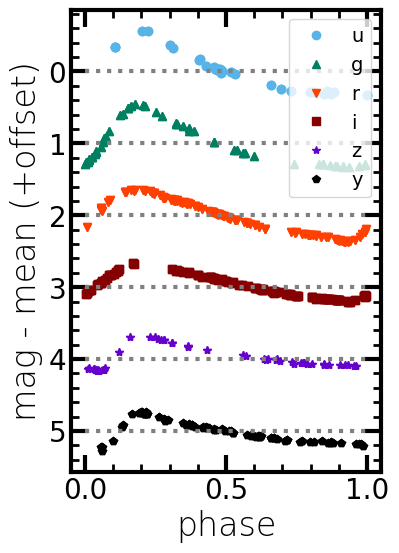

In [21]:
fig = plt.figure(figsize=(4, 6))

i = 0

for filter in plot_filter_labels:
    plt.plot(phase[filter], mags[filter]-np.mean(mags[filter]) + i,
             plot_filter_symbols[filter],
             color=plot_filter_colors[filter], label=filter)
    plt.hlines(i, 0, 1, linestyle=':', color='Gray')
    i += 1

plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('phase')
plt.ylabel('mag - mean (+offset)')
plt.minorticks_on()
plt.show()

...and all together:

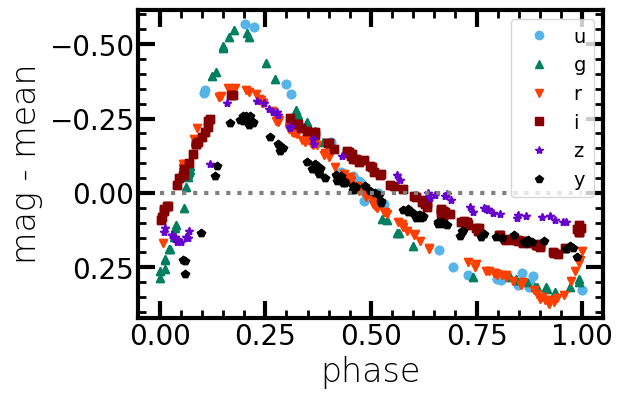

In [22]:
fig = plt.figure(figsize=(6, 4))

for filter in plot_filter_labels:
    plt.plot(phase[filter], mags[filter]-np.mean(mags[filter]),
             plot_filter_symbols[filter],
             color=plot_filter_colors[filter], label=filter)
plt.hlines(0, 0, 1, linestyle=':', color='Gray')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('phase')
plt.ylabel('mag - mean')
plt.minorticks_on()
plt.show()

Success! That looks like an RR Lyrae star. 

## 3. Identify Candidate RR Lyrae From Catalogs

Now that we know we can extract a lightcurve, find the star's period, and plot phased lightcurves for a _known_ RR Lyrae star, we move on to exploring how to _find_ candidate variables based on data in the catalogs.

Data products from difference image analysis (DIA), where sources are detected and measured on the _difference_ image resulting from subtracting an approriately scaled deep coadd template of the same sky area from a processed visit image (PVI), are a good place to check for transient and variable objects.

The three DIA products we will use are:

- `DiaObject`: table of all spatially unique objects detected in all difference images (all `DiaSources` associated by coordinate)
- `DiaSource`: table of sources detected in the difference images
- `ForcedSourceOnDiaObject`: table of forced photometry in all PVI and all difference images at the location of all `DiaObjects`

The DP0.2-era `DiaObject` table contains summary statistics for each object, which we can use to identify candidate variables.
In the future, this table will contain additional variability measurements as described in the Data Management Tech Note (DMTN) "Review of Timeseries Features", <a href="https://dmtn-118.lsst.io">DMTN-118</a>.

For simplicity, the RR Lyrae candidate search we will conduct in this section will be a cone search centered at the coordinates of the known RR Lyrae from the previous section (RA, Dec = 62.1479031, -35.799138) with a 5 degree search radius.

### 3.1 Query DiaObject and ForcedSourceOnDiaObject to Retrieve Candidates and Photometry

The `DiaObject` table has several parameters that characterize the variability of `DiaSource` flux measurements (see the <a href="https://dm.lsst.org/sdm_schemas/browser/dp02.html#DiaObject">DP0.2 Schema Browser</a> for a full list).
These include the min/max fluxes, and various statistical measures of the scatter in flux measurements.
A particularly useful statistic for variable stars is the "StetsonJ" statistic, based on <a href="https://ui.adsabs.harvard.edu/abs/1996PASP..108..851S/abstract">this 1996 paper</a>.
Variable stars have flux that varies more than expected based on the measurement uncertainties.
High values of the StetsonJ index should identify objects whose fluxes varied much more than expected -- i.e., variable stars.
Here we use StetsonJ>20, but users are encouraged to explore this and other statistics.

Here are all of the criteria we apply to our selection from `DiaObject`:

 1. g-band measurements only
 2. coordinates within 5 degrees of our chosen RA, Dec position
 3. `gTOTFluxSigma`/`gTOTFluxMean` > 0.25 -- the scatter in measured fluxes is larger than 25% relative to the mean
 4. `gTOTFluxSigma`/`gTOTFluxMean` < 1.25 -- the scatter in measured fluxes is no larger than 125% relative to the mean
 5. 18 < `diao_gmag` < 23 -- mean g magnitude between 18-23
 6. `gPSFluxNdata` > 30 -- at least 30 observations in g band
 7. `gPSFluxStetsonJ` > 20 -- StetsonJ index greater than 20 

In the ADQL query below, we implement all of these criteria and perform a table JOIN between `DiaObject` and `ForcedSourceOnDiaObject`,
the latter of which contains point-source forced-photometry measurements on processed visit images and difference images.
Since we are looking for **variable** candidates, which do appear in the template image,
we use the forced-photometry measurements from the **non-substracted** processed visit images (PVIs), also called the "direct" images.

We must perform one more table JOIN using the `ccdVisitId` from `FourcedSourceOnDiaObject` in order to get the MJD of each visit
from the `CcdVisit` table.
Note that the order of the table JOIN functions is important, and a different order may change the result of the search. 

In [23]:
query = "SELECT diao.diaObjectId, diao.ra, diao.decl, diao.nDiaSources, "\
        "diao.gPSFluxMin, diao.gPSFluxMax, diao.gPSFluxMean, diao.gPSFluxSigma, "\
        "diao.gPSFluxMAD, diao.gPSFluxChi2, diao.gPSFluxNdata, diao.gPSFluxSkew, "\
        "diao.gPSFluxStetsonJ, diao.gPSFluxPercentile05, diao.gPSFluxPercentile25, "\
        "diao.gPSFluxPercentile50, diao.gPSFluxPercentile75, diao.gPSFluxPercentile95, "\
        "diao.gTOTFluxMean, diao.gTOTFluxSigma, "\
        "scisql_nanojanskyToAbMag(diao.gTOTFluxMean) as diao_gmag, "\
        "fsodo.diaObjectId, "\
        "fsodo.ccdVisitId, fsodo.band, fsodo.psfFlux, fsodo.psfFluxErr, "\
        "fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, "\
        "cv.expMidptMJD, "\
        "scisql_nanojanskyToAbMag(fsodo.psfFlux) as fsodo_gmag "\
        "FROM dp02_dc2_catalogs_frdf.DiaObject as diao "\
        "JOIN dp02_dc2_catalogs_frdf.ForcedSourceOnDiaObject as fsodo "\
        "ON fsodo.diaObjectId = diao.diaObjectId "\
        "JOIN dp02_dc2_catalogs_frdf.CcdVisit as cv ON cv.ccdVisitId = fsodo.ccdVisitId "\
        "WHERE diao.gTOTFluxSigma/diao.gTOTFluxMean > 0.25 "\
        "AND diao.gTOTFluxSigma/diao.gTOTFluxMean < 1.25 "\
        "AND scisql_nanojanskyToAbMag(diao.gTOTFluxMean) > 18 "\
        "AND scisql_nanojanskyToAbMag(diao.gTOTFluxMean) < 23 "\
        "AND diao.gPSFluxNdata > 30 "\
        "AND diao.gPSFluxStetsonJ > 20 "\
        "AND fsodo.band = 'g' "\
        "AND CONTAINS(POINT('ICRS', diao.ra, diao.decl), "\
        "CIRCLE('ICRS',"+str(ra_known_rrl)+", "+str(dec_known_rrl)+", 5)) = 1 "

results = service.search(query)
fsodo_sources = results.to_table()

Uncomment the following cell to view the results table.

In [24]:
#fsodo_sources

We can also check out the number of unique `DiaObjects` and the total number of measurements from the following cell.

In [25]:
print(len(fsodo_sources), len(np.unique(fsodo_sources['diaObjectId'])))

1404 14


The statement and its output above tells us that the query returned 14 unique `DiaObjects`, with a total of 702 measurements in `ForcedSourceOnDiaObject`.

In the following cell, we show the unique `DiaObjects` and their coordinates.


In [26]:
unique(fsodo_sources,keys = 'diaObjectId')['diaObjectId','ra','decl']

diaObjectId,ra,decl
,deg,deg
int64,float64,float64
1567428592185376787,59.4814837,-37.7323315
1567762843720221100,62.5202159,-37.8646632
1568246628836442456,62.5202159,-37.8646632
1568950316278219135,67.2951662,-38.4159654
1569082257673552562,67.0155078,-37.8278368
1569135034231685181,67.4679316,-37.6786425
1651510445384663056,62.6536501,-35.9700212
1651589610221862935,62.1479038,-35.7991348


**Important Note:** Due to a likely issue with source association, the same variable can be identified with multiple `DiaObject` IDs. As can be seen above, this has occurred in this search, where the `DiaObjects` with IDs 1567762843720221100 and 1568246628836442456 are associated with the same candidate. Scientists on the Rubin Community Science team (CST) are currently investigating this issue.

### 3.2 Run the Lomb-Scargle Frequency Algorithm on All Candidates

In [27]:
objids = np.unique(fsodo_sources['diaObjectId'])
LSpower = []
LSfreq = []

minfreq = 1 / (1.25*u.d)
maxfreq = 1 / (0.05*u.d)
for objid in objids:
    findobj = (fsodo_sources['diaObjectId'] == objid)
    obj_mjd_days = np.array(fsodo_sources[findobj]['expMidptMJD']) * u.day
    obj_mags = np.array(fsodo_sources[findobj]['fsodo_gmag'])
    obj_frequency, obj_power =\
        LombScargle(obj_mjd_days, obj_mags).autopower(minimum_frequency=minfreq,
                                                      maximum_frequency=maxfreq)
    max_power = np.argmax(obj_power)
    LSpower.append(obj_power[max_power])
    LSfreq.append(obj_frequency[max_power].value)

LSpower = np.array(LSpower)
LSfreq = np.array(LSfreq)

### 3.3 Plot Lightcurves of Several Candidates

Let's examine several candidates. To see if they look like RR Lyrae (and whether we identified the correct period), plot phased lightcurves based on the frequencies from the Lomb-Scargle analysis.

Specifically, we'll be looking at the candidates with `DIAObject` IDs 1567428592185376787, 1567762843720221100, and 1651589610221862935.

DiaObjectID:  1567428592185376787 
 RA:  59.4814837 
 Dec:  -37.7323315 
 period:  1.25


/tmp/ipykernel_15079/1903130074.py:18: RuntimeWarning: Mean of empty slice
  plt.plot(obj_phase, obj_mags-np.nanmean(obj_mags), plot_filter_symbols['g'],


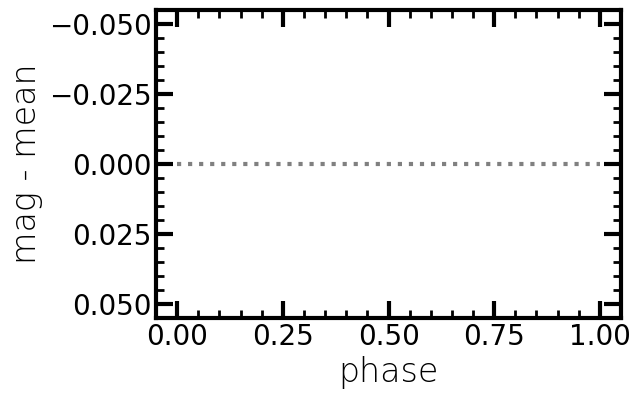

DiaObjectID:  1567762843720221100 
 RA:  62.5202159 
 Dec:  -37.8646632 
 period:  1.25


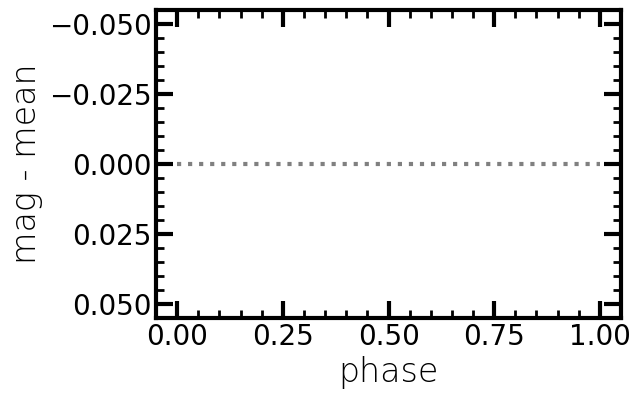

DiaObjectID:  1651589610221862935 
 RA:  62.1479038 
 Dec:  -35.7991348 
 period:  1.25


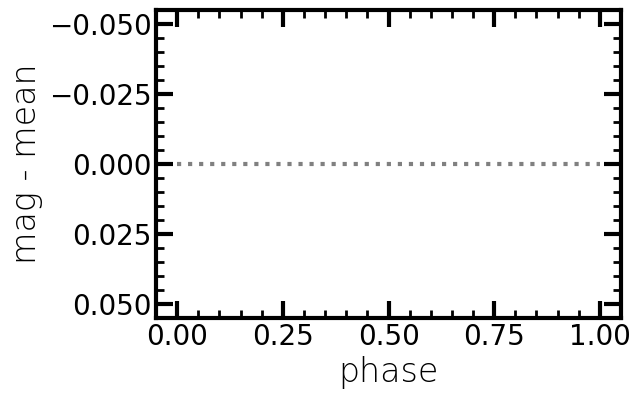

In [28]:
objid_index = [0,1,7]

for i in objid_index:
    fig = plt.figure(figsize=(6, 4))
    findobj = (fsodo_sources['diaObjectId'] == objids[i])
    obj_mjd_days = np.array(fsodo_sources[findobj]['expMidptMJD']) * u.day
    obj_mags = np.array(fsodo_sources[findobj]['fsodo_gmag'])
    obj_period = 1 / LSfreq[i]
    print('DiaObjectID: ', objids[i],
          '\n RA: ', fsodo_sources[findobj]['ra'][0],
          '\n Dec: ', fsodo_sources[findobj]['decl'][0],
          '\n period: ', obj_period)

    t0 = 0.0
    obj_mjd_norm = (obj_mjd_days.value - t0) / obj_period
    obj_phase = np.mod(obj_mjd_norm, 1.0)

    plt.plot(obj_phase, obj_mags-np.nanmean(obj_mags), plot_filter_symbols['g'],
             color=plot_filter_colors['g'], ms=8)
    plt.hlines(0, 0, 1, linestyle=':', color='Gray')

    plt.gca().invert_yaxis()
    plt.xlabel('phase')
    plt.ylabel('mag - mean')
    plt.minorticks_on()
    plt.show()

Hooray! A few of these look like actual RR Lyrae variables! Some of the others either aren't RR Lyrae, or have mis-identified periods.

Note that the lightcurve with `DiaObjectId` 1651589610221862935 is the same as the one we target in Section 2.

### 3.4 Cautionary tale: comparing lightcurves from ForcedSourceOnDiaObject vs. DiaSource

**What if we used `DiaSource` instead of `ForcedSourceOnDiaObject`?** 

In this section we demonstrate the results when we perform a table JOIN between `DiaObject` and `DiaSource` instead of `ForcedSourceOnDiaObject`.
Using `DiaSource` will only provide photometry measurements for visits in which the variable star is detected in the 
difference image (the detection threshold is a signal-to-noise ratio greater than 5).
Variable stars will not be detected in a difference image when they are nearly the same brightness as they are in the template image,
leaving a very small flux residual in the difference image.

As demonstrated below, using `DiaSource` instead of `ForcedSourceOnDiaObject` can leave some points out of the
lightcurve and impact any derived parameters like the period.

First, we perform a similar search query as Sec. 3.1 except we use a table JOIN with `DiaSource`.
Note that `totFlux` from `DiaSource` provides the forced PSF-flux measurement on the direct image, not the difference image.

In [29]:
query = "SELECT diao.diaObjectId, diao.ra, diao.decl, diao.nDiaSources, "\
        "diao.gPSFluxMin, diao.gPSFluxMax, diao.gPSFluxMean, diao.gPSFluxSigma, "\
        "diao.gPSFluxMAD, diao.gPSFluxChi2, diao.gPSFluxNdata, diao.gPSFluxSkew, "\
        "diao.gPSFluxStetsonJ, diao.gPSFluxPercentile05, diao.gPSFluxPercentile25, "\
        "diao.gPSFluxPercentile50, diao.gPSFluxPercentile75, diao.gPSFluxPercentile95, "\
        "diao.gTOTFluxMean, diao.gTOTFluxSigma, "\
        "scisql_nanojanskyToAbMag(diao.gTOTFluxMean) as diao_gmag, "\
        "dias.diaSourceId, dias.diaObjectId, dias.midPointTai, "\
        "dias.ccdVisitId, dias.filterName, dias.psFlux, dias.psFluxErr, "\
        "dias.totFlux, dias.totFluxErr, "\
        "scisql_nanojanskyToAbMag(dias.totFlux) as dias_gmag "\
        "FROM dp02_dc2_catalogs_frdf.DiaObject as diao "\
        "JOIN dp02_dc2_catalogs_frdf.DiaSource as dias "\
        "ON dias.diaObjectId = diao.diaObjectId "\
        "WHERE diao.gTOTFluxSigma/diao.gTOTFluxMean > 0.25 "\
        "AND diao.gTOTFluxSigma/diao.gTOTFluxMean < 1.25 "\
        "AND scisql_nanojanskyToAbMag(diao.gTOTFluxMean) > 18 "\
        "AND scisql_nanojanskyToAbMag(diao.gTOTFluxMean) < 23 "\
        "AND diao.gPSFluxNdata > 30 "\
        "AND diao.gPSFluxStetsonJ > 20 "\
        "AND dias.filterName = 'g' "\
        "AND CONTAINS(POINT('ICRS', diao.ra, diao.decl), "\
        "CIRCLE('ICRS',"+str(ra_known_rrl)+", "+str(dec_known_rrl)+", 5)) = 1 "

results = service.search(query)
dia_sources = results.to_table()

In [30]:
print(len(dia_sources), len(np.unique(dia_sources['diaObjectId'])))

549 14


The query returned 14 unique `DiaObjects`, the same as the query from Section 3.1.
However, the query with `DiaSource` resulted in a total of 549 measurements, whereas the query with `ForcedSourceOnDiaObject` resulted in a total of 702 measurements.

We now repeat the same Lomb-Scargle analysis with the `DiaSource` results.

In [31]:
objids_dia = np.unique(dia_sources['diaObjectId'])
LSpower_dia = []
LSfreq_dia = []

minfreq = 1 / (1.25*u.d)
maxfreq = 1 / (0.05*u.d)
for objid in objids:
    findobj = (dia_sources['diaObjectId'] == objid)
    obj_mjd_days = np.array(dia_sources[findobj]['midPointTai']) * u.day
    obj_mags = np.array(dia_sources[findobj]['dias_gmag'])
    obj_frequency, obj_power =\
        LombScargle(obj_mjd_days, obj_mags).autopower(minimum_frequency=minfreq,
                                                      maximum_frequency=maxfreq)
    max_power = np.argmax(obj_power)
    LSpower_dia.append(obj_power[max_power])
    LSfreq_dia.append(obj_frequency[max_power].value)

LSpower_dia = np.array(LSpower_dia)
LSfreq_dia = np.array(LSfreq_dia)

We now plot the resulting phased lightcurves from the `DiaSource` catalog (open markers) and the `ForcedSourceOnDiaObject` catalog (filled markers) of the same 3 selected candidates.

DiaObjectID:  1567428592185376787 
 RA:  59.4814837 
 Dec:  -37.7323315 
 period (DiaSource):  1.0418601712065714 
 period (ForcedSourceOnDiaObject) 1.25


/tmp/ipykernel_15079/2660292665.py:26: RuntimeWarning: Mean of empty slice
  plt.plot(obj_phase_fsodo, obj_mags_fsodo-np.nanmean(obj_mags_fsodo), plot_filter_symbols['g'],


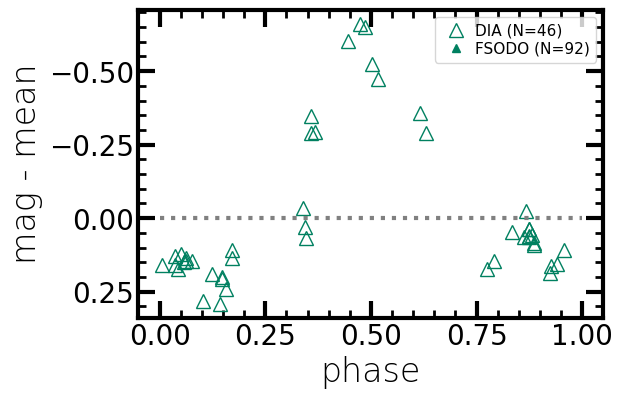

DiaObjectID:  1567762843720221100 
 RA:  62.5202159 
 Dec:  -37.8646632 
 period (DiaSource):  0.6515237959596147 
 period (ForcedSourceOnDiaObject) 1.25


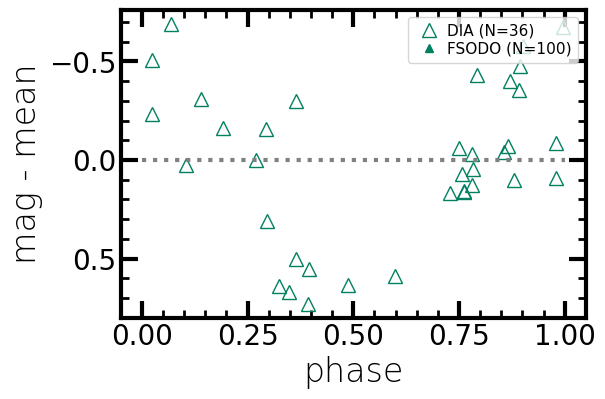

DiaObjectID:  1651589610221862935 
 RA:  62.1479038 
 Dec:  -35.7991348 
 period (DiaSource):  0.5095414310681814 
 period (ForcedSourceOnDiaObject) 1.25


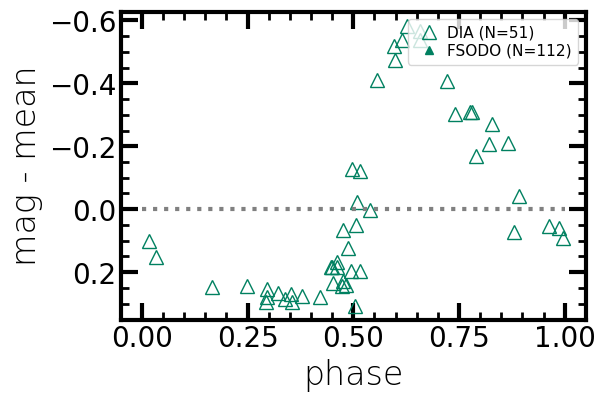

In [32]:
for i in objid_index:
    fig = plt.figure(figsize=(6, 4))    
    findobj_fsodo = (fsodo_sources['diaObjectId'] == objids[i])
    findobj_dia = (dia_sources['diaObjectId'] == objids[i])
    obj_mjd_days_dia = np.array(dia_sources[findobj_dia]['midPointTai']) * u.day
    obj_mags_dia = np.array(dia_sources[findobj_dia]['dias_gmag'])
    obj_mjd_days_fsodo = np.array(fsodo_sources[findobj_fsodo]['expMidptMJD']) * u.day
    obj_mags_fsodo = np.array(fsodo_sources[findobj_fsodo]['fsodo_gmag'])
    obj_period_fsodo = 1 / LSfreq[i]
    obj_period_dia = 1 / LSfreq_dia[i]
    print('DiaObjectID: ', objids[i],
          '\n RA: ', fsodo_sources[findobj_fsodo]['ra'][0],
          '\n Dec: ', fsodo_sources[findobj_fsodo]['decl'][0],
          '\n period (DiaSource): ', obj_period_dia,
          '\n period (ForcedSourceOnDiaObject)',obj_period_fsodo)
    
    t0 = 0.0
    obj_mjd_norm_fsodo = (obj_mjd_days_fsodo.value - t0) / obj_period_fsodo
    obj_mjd_norm_dia = (obj_mjd_days_dia.value - t0) / obj_period_dia
    obj_phase_dia = np.mod(obj_mjd_norm_dia, 1.0)
    obj_phase_fsodo = np.mod(obj_mjd_norm_fsodo, 1.0)

    plt.plot(obj_phase_dia, obj_mags_dia-np.nanmean(obj_mags_dia), plot_filter_symbols['g'],
             markerfacecolor = 'none', mec=plot_filter_colors['g'], ms=10, 
             label='DIA (N=%i)' % len(obj_phase_dia))
    plt.plot(obj_phase_fsodo, obj_mags_fsodo-np.nanmean(obj_mags_fsodo), plot_filter_symbols['g'],
             color=plot_filter_colors['g'], ms=6, label='FSODO (N=%i)' % len(obj_phase_fsodo))
    plt.hlines(0, 0, 1, linestyle=':', color='Gray')

    plt.gca().invert_yaxis()
    plt.legend(loc='upper right', labelspacing=0.2, handletextpad=0.2, fontsize=11)
    plt.xlabel('phase')
    plt.ylabel('mag - mean')
    plt.minorticks_on()
    plt.show()

Note that the number of measurements is always greater from the `ForcedSourceOnDiaObject` results.

The plots demonstrate the possible deviations in this analysis using the different catalogs.
Not only can the periods differ from using the different catalogs (e.g. 1567762843720221100), but the phase may also be offset due to additional measurements provided by the `ForcedSourceOnDiaObject` catalog. 

Lastly, we can estimate the fraction of candidates that will have different periods between the `ForcedSourceOnDiaObject` and `DiaSource` catalogs. 

In [33]:
1-(LSfreq_dia-LSfreq).tolist().count(0.0)/len(LSfreq)

0.8571428571428572

We see that **~70%** of the identified candidates exhibit different periods from both catalogs.

Plot a histogram of the absolute difference in the periods measured from `ForcedSourceOnDiaObject` and `DiaSource`.

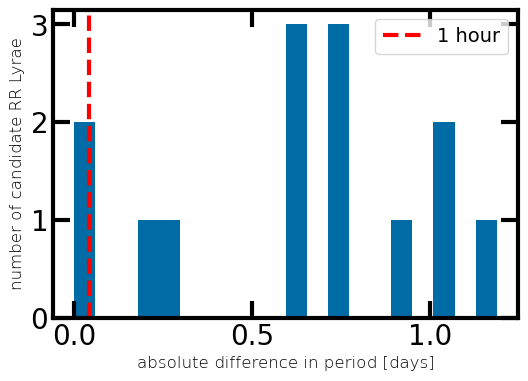

In [34]:
period_difference = np.abs((1.0 / LSfreq_dia) - (1.0 / LSfreq))

fig = plt.figure(figsize=(6, 4))
plt.hist(period_difference, bins=20)
plt.axvline(1.0 / 24.0, ls='--', color='red', label='1 hour')
plt.legend(loc='upper right')
plt.xlabel('absolute difference in period [days]', fontsize=12)
plt.ylabel('number of candidate RR Lyrae', fontsize=12)
plt.show()

Above, we can see that only 5 of the 14 candidate RR Lyrae (which have not been confirmed to _be_ RR Lyrae) have
periods that change by less than 1 hour when the incomplete `DiaSource` photometry is used instead of `ForcedSourceOnDiaObject`.

> Note: because of the source association issue pointed out at the end of Section 3.1, there are two `DiaObject` IDs from
the search that correspond to the same candidate.
This means that the fraction of unique RR Lyrae stars with different periods should actually be _greater_ than ~70%.

## 4. Exercises for the learner

There are many further explorations one could try as extensions of this notebook. Some examples:

1. Experiment with ways to identify periodic signals in the data.
2. Refine the selection criteria for finding candidates.
3. Compare results from candidate search to the true star lightcurves from the DESC truth tables.

...and many more. Have fun!